In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings("ignore")


   Accident_Severity Accident_Severity_Label
0                2.0                 Serious
1                3.0                  Slight
2                3.0                  Slight
3                3.0                  Slight
4                3.0                  Slight


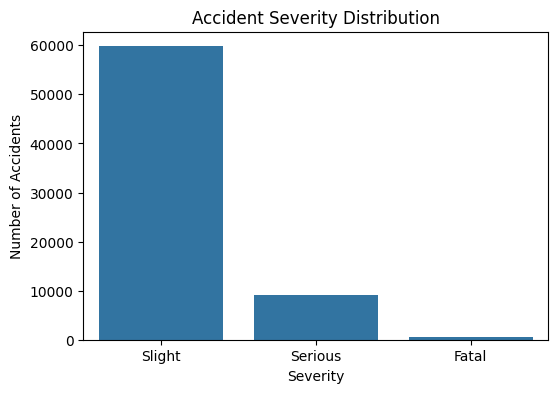

In [ ]:
# Step 1: Load your accident data CSV
df = pd.read_csv("/content/AccidentLondonBoroughs2223.csv")

# Step 2: Load metadata XLS file with all mappings
meta = pd.read_excel("/content/Road-Accident-Safety-Data-Guide.xls", sheet_name=None)

# Step 3: Utility function to convert code-label sheets into dictionaries
def load_meta(sheet_df):
    sheet_df.columns = [c.lower().strip() for c in sheet_df.columns]
    return dict(zip(sheet_df['code'], sheet_df['label']))

# Step 4: Prepare mappings (match column names in CSV)
mappings = {
    "Police_Force": "Police Force",
    "Accident_Severity": "Accident Severity",
    "Day_of_Week": "Day of Week",
    "Road_Type": "Road Type",
    "Weather_Conditions": "Weather",
    "Road_Surface_Conditions": "Road Surface",
    "Light_Conditions": "Light Conditions"
}

# Step 5: Apply mappings and create new label columns
for col, sheet in mappings.items():
    if col in df.columns and sheet in meta:
        mapping_dict = load_meta(meta[sheet])
        df[col + "_Label"] = df[col].map(mapping_dict)

# Step 6: Check if label column created successfully
print(df[['Accident_Severity', 'Accident_Severity_Label']].head())

# Step 7: Plot: Accident Severity Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="Accident_Severity_Label", order=["Slight", "Serious", "Fatal"])
plt.title("Accident Severity Distribution")
plt.ylabel("Number of Accidents")
plt.xlabel("Severity")
plt.show()


In [ ]:
print(df['Accident_Severity'].unique())


[ 2.  3.  1. nan]


In [ ]:
# Show all column names
print(df.columns.tolist())


['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time', 'Local_Authority_District', 'Local_Authority_Highway', '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location', 'Police_Force_Label', 'Accident_Severity_Label', 'Day_of_Week_Label', 'Road_Type_Label', 'Weather_Conditions_Label', 'Road_Surface_Conditions_Label', 'Light_Conditions_Label']


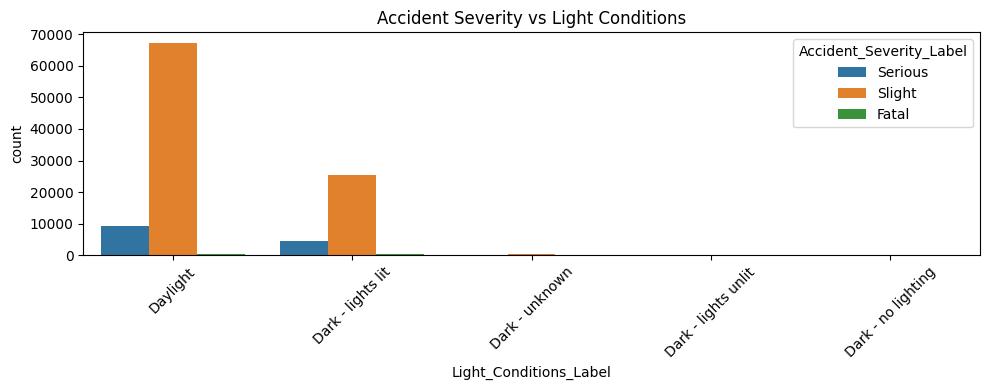

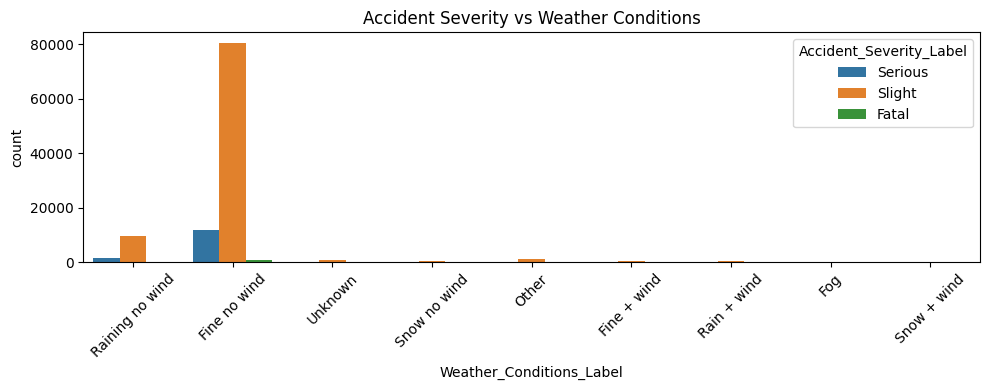

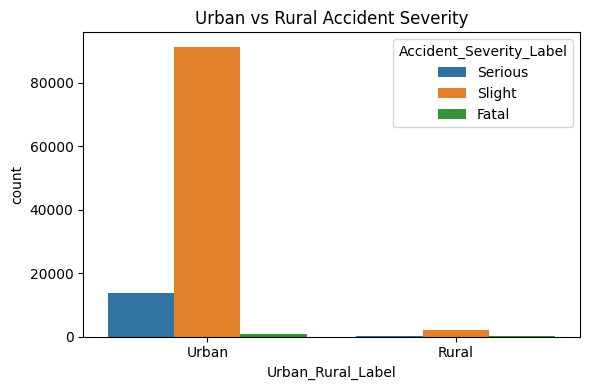

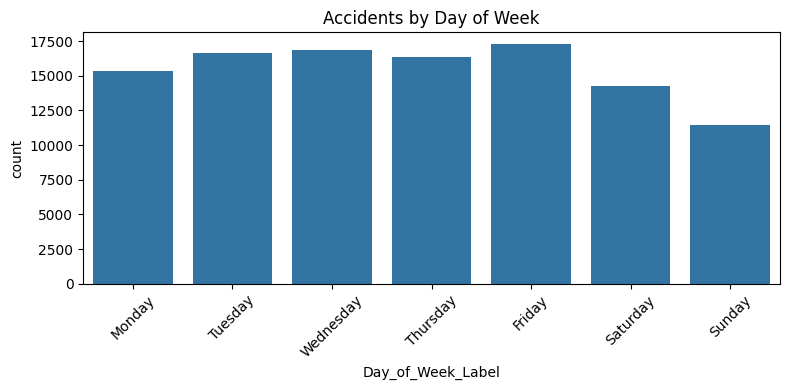

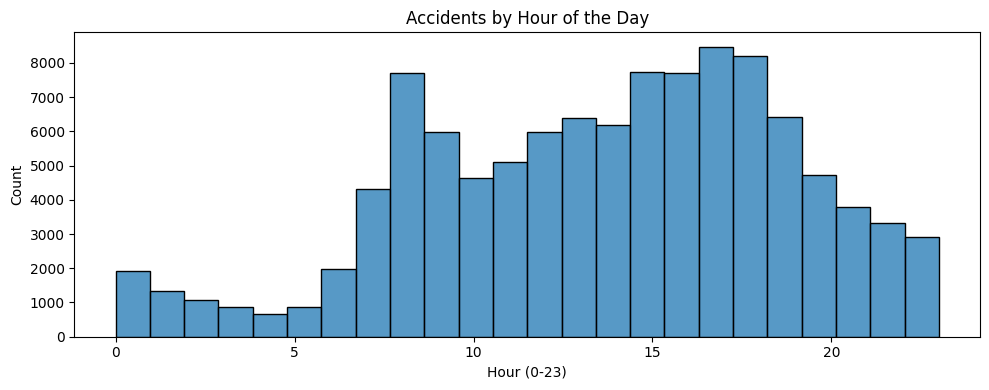

In [ ]:
# Step 1: Load Dataset
df = pd.read_csv("/content/AccidentLondonBoroughs2223.csv")

# Step 2: Metadata Mappings (a few examples for now)
accident_severity_map = {1: 'Fatal', 2: 'Serious', 3: 'Slight'}
day_of_week_map = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
urban_rural_map = {1: 'Urban', 2: 'Rural', 3: 'Unallocated'}
light_conditions_map = {
    1: 'Daylight', 4: 'Dark - lights lit', 5: 'Dark - lights unlit',
    6: 'Dark - no lighting', 7: 'Dark - unknown'
}
weather_map = {
    1: 'Fine no wind', 2: 'Raining no wind', 3: 'Snow no wind',
    4: 'Fine + wind', 5: 'Rain + wind', 6: 'Snow + wind',
    7: 'Fog', 8: 'Other', 9: 'Unknown'
}

# Step 3: Apply Mappings
df['Accident_Severity_Label'] = df['Accident_Severity'].map(accident_severity_map)
df['Day_of_Week_Label'] = df['Day_of_Week'].map(day_of_week_map)
df['Urban_Rural_Label'] = df['Urban_or_Rural_Area'].map(urban_rural_map)
df['Light_Conditions_Label'] = df['Light_Conditions'].map(light_conditions_map)
df['Weather_Conditions_Label'] = df['Weather_Conditions'].map(weather_map)

# Step 4: Problem 1 – Severity vs Weather & Light (EDA)
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='Light_Conditions_Label', hue='Accident_Severity_Label')
plt.title("Accident Severity vs Light Conditions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='Weather_Conditions_Label', hue='Accident_Severity_Label')
plt.title("Accident Severity vs Weather Conditions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 5: Problem 2 – Urban vs Rural Area
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Urban_Rural_Label', hue='Accident_Severity_Label')
plt.title("Urban vs Rural Accident Severity")
plt.tight_layout()
plt.show()

# Step 6: Problem 3 – Accidents by Day and Time
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Day_of_Week_Label', order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
plt.title("Accidents by Day of Week")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Convert Time to hour for further analysis
df['Hour'] = pd.to_datetime(df['Time'], errors='coerce').dt.hour

plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='Hour', bins=24, kde=False)
plt.title("Accidents by Hour of the Day")
plt.xlabel("Hour (0-23)")
plt.tight_layout()
plt.show()


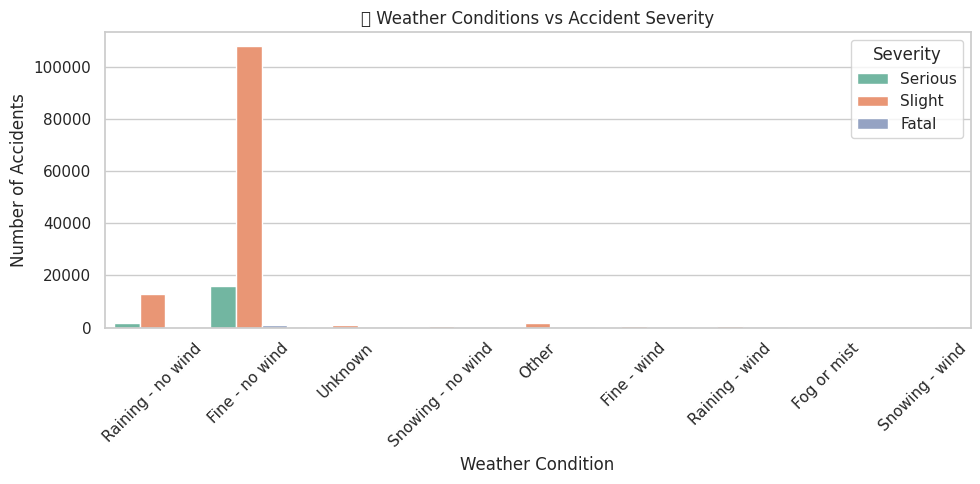

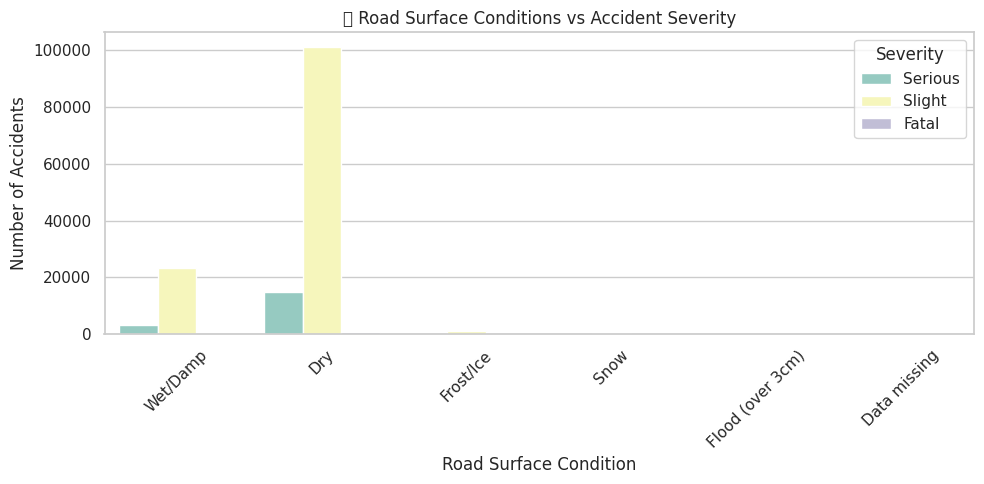

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# STEP 1: Load the CSV (upload required first)
df = pd.read_csv("/content/AccidentLondonBoroughs2223.csv")

# STEP 2: Replace codes with readable labels
weather_map = {
    1: "Fine - no wind",
    2: "Raining - no wind",
    3: "Snowing - no wind",
    4: "Fine - wind",
    5: "Raining - wind",
    6: "Snowing - wind",
    7: "Fog or mist",
    8: "Other",
    9: "Unknown",
    -1: "Data missing"
}

road_surface_map = {
    1: "Dry",
    2: "Wet/Damp",
    3: "Snow",
    4: "Frost/Ice",
    5: "Flood (over 3cm)",
    6: "Oil/Mud",
    7: "Other",
    -1: "Data missing"
}

severity_map = {
    1: "Fatal",
    2: "Serious",
    3: "Slight"
}

df['Weather_Conditions_Label'] = df['Weather_Conditions'].map(weather_map)
df['Road_Surface_Conditions_Label'] = df['Road_Surface_Conditions'].map(road_surface_map)
df['Accident_Severity_Label'] = df['Accident_Severity'].map(severity_map)

# STEP 3: Bar Plot – Weather Conditions vs Severity
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Weather_Conditions_Label', hue='Accident_Severity_Label', palette='Set2')
plt.title("🌦️ Weather Conditions vs Accident Severity")
plt.xticks(rotation=45)
plt.xlabel("Weather Condition")
plt.ylabel("Number of Accidents")
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

# STEP 4: Bar Plot – Road Surface vs Severity
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Road_Surface_Conditions_Label', hue='Accident_Severity_Label', palette='Set3')
plt.title(" Road Surface Conditions vs Accident Severity")
plt.xticks(rotation=45)
plt.xlabel("Road Surface Condition")
plt.ylabel("Number of Accidents")
plt.legend(title='Severity')
plt.tight_layout()
plt.show()


In [ ]:
# Step 2: Define correct data types based on metadata
categorical_cols = [
    'Police_Force', 'Accident_Severity', 'Day_of_Week', 'Local_Authority_District',
    'Local_Authority_Highway', '1st_Road_Class', 'Road_Type', 'Junction_Detail', 'Junction_Control',
    '2nd_Road_Class', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities',
    'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions',
    'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area',
    'Did_Police_Officer_Attend_Scene_of_Accident'
]

numeric_cols = [
    'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude',
    'Number_of_Vehicles', 'Number_of_Casualties', '1st_Road_Number', '2nd_Road_Number', 'Speed_limit'
]

string_cols = ['Accident_Index', 'LSOA_of_Accident_Location']

datetime_cols = ['Date', 'Time']

# Step 3: Apply correct data types

# Categorical
for col in categorical_cols:
    df[col] = df[col].astype("category")

# Numeric
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# String
for col in string_cols:
    df[col] = df[col].astype(str)

# Date/Time
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y", errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], format="%H:%M", errors='coerce').dt.time

# Step 4: Verify data types
print("\n Final Column Data Types:")
print(df.dtypes)



 Final Column Data Types:
Accident_Index                                         object
Location_Easting_OSGR                                   int64
Location_Northing_OSGR                                float64
Longitude                                             float64
Latitude                                              float64
Police_Force                                         category
Accident_Severity                                    category
Number_of_Vehicles                                    float64
Number_of_Casualties                                  float64
Date                                           datetime64[ns]
Day_of_Week                                          category
Time                                                   object
Local_Authority_District                             category
Local_Authority_Highway                              category
1st_Road_Class                                       category
1st_Road_Number                            

In [ ]:
from scipy.stats import skew, kurtosis
# For better plots
sns.set(style="whitegrid")


In [ ]:
# Step 1: Dataset Shape
print("Total Records:", df.shape[0])
print("Total Variables (Columns):", df.shape[1])

Total Records: 108235
Total Variables (Columns): 38


In [ ]:
# Step 2: Summary for Numeric Variables
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

summary_stats = df[numeric_cols].describe().T
summary_stats["mode"] = df[numeric_cols].mode().iloc[0]
summary_stats["skewness"] = df[numeric_cols].skew()
summary_stats["kurtosis"] = df[numeric_cols].kurtosis()
print("\nNumeric Variable Summary:\n")
print(summary_stats[["min", "max", "mean", "std", "mode", "skewness", "kurtosis"]])


Numeric Variable Summary:

                                  min            max           mean  \
Location_Easting_OSGR        5.000000  561130.000000  530901.806116   
Location_Northing_OSGR  156110.000000  200910.000000  180621.250716   
Longitude                   -0.510087       0.322103      -0.115034   
Latitude                    51.289060      51.691639      51.509221   
Number_of_Vehicles           1.000000      14.000000       1.793263   
Number_of_Casualties         1.000000      40.000000       1.202792   
1st_Road_Number              0.000000    5210.000000     537.785483   
Speed_limit                 10.000000      70.000000      31.164144   
2nd_Road_Number             -1.000000    5210.000000     195.624175   
Hour                         0.000000      23.000000      13.683584   

                                 std           mode  skewness    kurtosis  
Location_Easting_OSGR   10148.457046  533650.000000 -1.371009   69.081044  
Location_Northing_OSGR   7481.466819  

In [ ]:
# Step 3: Summary for Categorical Variables
categorical_cols = df.select_dtypes(include="category").columns.tolist()

print("\n Categorical Variable Summary:\n")
for col in categorical_cols:
    print(f" {col}:")
    print("  Unique Values:", df[col].nunique())
    print("  Mode:", df[col].mode().values[0])
    print("  Value Counts:\n", df[col].value_counts(), "\n")



 Categorical Variable Summary:

 Police_Force:
  Unique Values: 2
  Mode: 1.0
  Value Counts:
 Police_Force
1.0     106589
48.0      1645
Name: count, dtype: int64 

 Accident_Severity:
  Unique Values: 3
  Mode: 3.0
  Value Counts:
 Accident_Severity
3.0    93393
2.0    13993
1.0      848
Name: count, dtype: int64 

 Day_of_Week:
  Unique Values: 7
  Mode: 6.0
  Value Counts:
 Day_of_Week
6.0    17272
4.0    16887
3.0    16664
5.0    16334
2.0    15320
7.0    14281
1.0    11476
Name: count, dtype: int64 

 Local_Authority_District:
  Unique Values: 33
  Mode: 1.0
  Value Counts:
 Local_Authority_District
1.0      7344
9.0      5308
8.0      4657
30.0     4273
17.0     4074
5.0      4055
4.0      4040
20.0     4002
2.0      3953
27.0     3832
12.0     3573
13.0     3461
15.0     3383
14.0     3349
32.0     3252
26.0     3252
3.0      3249
7.0      3239
11.0     3234
10.0     3217
28.0     3138
25.0     3100
6.0      3055
19.0     2973
31.0     2702
16.0     2372
18.0     2072
21.0    

 Missing Values Summary:
                            Missing Count  Missing %
LSOA_of_Accident_Location            173   0.119128

 Outliers Detected (Z-score > 3):
 Location_Easting_OSGR                             1
Location_Northing_OSGR                           44
Longitude                                         1
Latitude                                         49
Police_Force                                   1983
Accident_Severity                              1131
Number_of_Vehicles                             2077
Number_of_Casualties                           5196
Local_Authority_District                       1983
1st_Road_Number                                7436
Speed_limit                                    5067
2nd_Road_Number                                4397
Pedestrian_Crossing-Human_Control               303
Pedestrian_Crossing-Physical_Facilities        1072
Light_Conditions                                526
Weather_Conditions                             4208
Ro

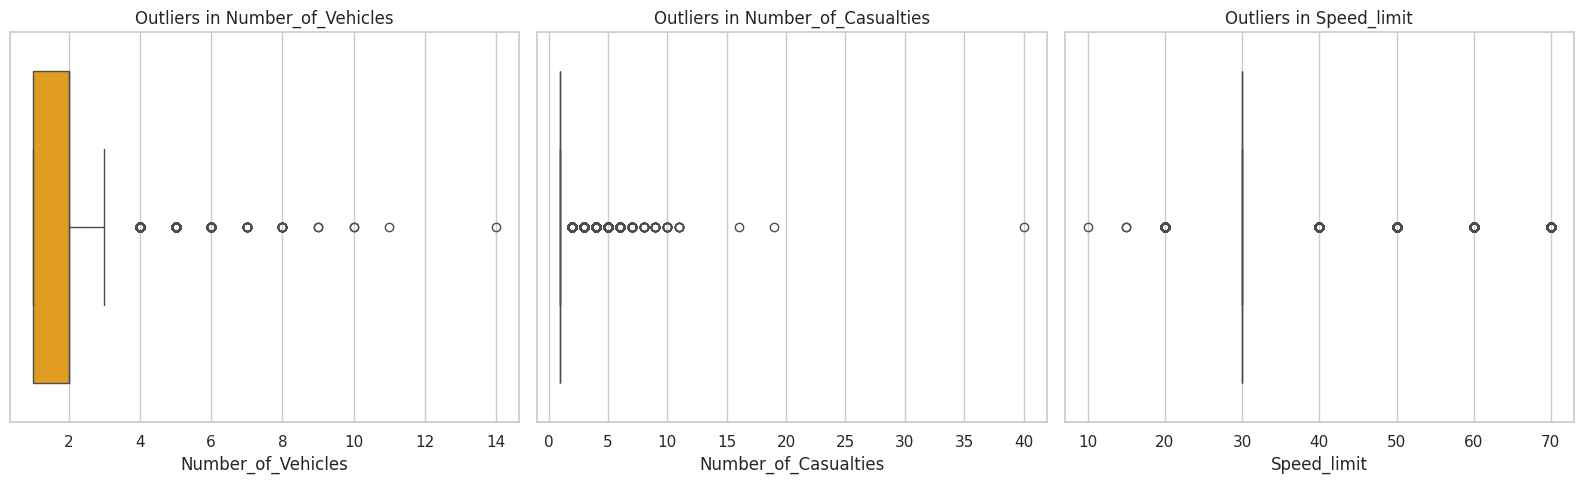


📉 Imbalanced Class Check:
Accident_Severity is imbalanced:
Accident_Severity
3    86.575037
2    12.646156
1     0.778808
Name: proportion, dtype: float64

Weather_Conditions is imbalanced:
Weather_Conditions
1    85.810001
2    10.288386
8     1.390974
9     0.808417
3     0.506122
4     0.497858
5     0.447591
7     0.211400
6     0.039250
Name: proportion, dtype: float64

Road_Type is imbalanced:
Road_Type
6    80.571126
3    12.007823
1     4.212860
2     2.278580
7     0.641087
9     0.288524
Name: proportion, dtype: float64


 Value Ranges of Numeric Columns:
Location_Easting_OSGR: min = 503590, max = 561130
Location_Northing_OSGR: min = 156110, max = 200910
Longitude: min = -0.510087, max = 0.322103
Latitude: min = 51.28906, max = 51.691639
Police_Force: min = 1, max = 48
Accident_Severity: min = 1, max = 3
Number_of_Vehicles: min = 1, max = 14
Number_of_Casualties: min = 1, max = 40
Day_of_Week: min = 1, max = 7
Local_Authority_District: min = 1, max = 570
1st_Road_Class: min 

In [ ]:
# Step 1: Load data
df = pd.read_csv("/content/AccidentLondonBoroughs2223.csv")

# Step 2: Check missing values
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
missing_df = missing_df[missing_df['Missing Count'] > 0]
print(" Missing Values Summary:\n", missing_df)

# Step 3: Check numeric columns for outliers using z-score
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
z_scores = df[numeric_cols].apply(zscore)
outliers = (np.abs(z_scores) > 3).sum()
print("\n Outliers Detected (Z-score > 3):\n", outliers[outliers > 0])

# Step 4: Plot boxplots for visualizing outliers
plt.figure(figsize=(16, 5))
for i, col in enumerate(['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x=df[col], color='orange')
    plt.title(f'Outliers in {col}')
plt.tight_layout()
plt.show()

# Step 5: Check for imbalanced categorical variables
categorical_cols = df.select_dtypes(include='object').columns.tolist() + [
    'Accident_Severity', 'Weather_Conditions', 'Day_of_Week', 'Road_Type'
]
print("\n📉 Imbalanced Class Check:")
for col in categorical_cols:
    if col in df.columns:
        value_counts = df[col].value_counts(normalize=True) * 100
        if value_counts.max() > 80:
            print(f"{col} is imbalanced:")
            print(value_counts)
            print()

# Step 6: Range comparison for numeric variables
print("\n Value Ranges of Numeric Columns:")
for col in numeric_cols:
    print(f"{col}: min = {df[col].min()}, max = {df[col].max()}")

# Step 7: Duplicates
duplicates = df.duplicated().sum()
print(f"\n Duplicate Rows Found: {duplicates}")


In [ ]:
# Step 1: Load data (adjust path if needed)
df = pd.read_csv("/content/AccidentLondonBoroughs2223.csv")

irrelevant_cols = ['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
                   'Longitude', 'Latitude', 'LSOA_of_Accident_Location', 'Local_Authority_Highway']
df.drop(columns=irrelevant_cols, inplace=True)

# Convert date & time
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Time'] = pd.to_datetime(df['Time'], errors='coerce').dt.time

df.dropna(subset=['Accident_Severity'], inplace=True)

# Fill numerical missing values with median
num_cols = ['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Fill categorical columns with mode
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


# Step 5: Remove Duplicates

df.drop_duplicates(inplace=True)


# Step 6: Detect & Remove Outliers (Z-score method)

z_scores = np.abs(stats.zscore(df[num_cols]))
df = df[(z_scores < 3).all(axis=1)]  # keep rows with z-score < 3


# Step 7: Encode Categorical Features

le = LabelEncoder()
encoded_df = df.copy()

for col in df.select_dtypes(include='object').columns:
    encoded_df[col] = le.fit_transform(df[col])


# Step 8: Normalize/Scale Numerical Features

scaler = StandardScaler()
encoded_df[num_cols] = scaler.fit_transform(encoded_df[num_cols])


# Step 9: Final Feature Selection (based on Task 3.1)

final_features = ['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit',
                  'Weather_Conditions', 'Road_Surface_Conditions', 'Light_Conditions',
                  'Day_of_Week', 'Urban_or_Rural_Area', 'Road_Type']

X = encoded_df[final_features]
y = encoded_df['Accident_Severity']


# Step 10: Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check shape
print(" Preprocessing Complete!")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


 Preprocessing Complete!
X_train shape: (107124, 9)
X_test shape: (26781, 9)


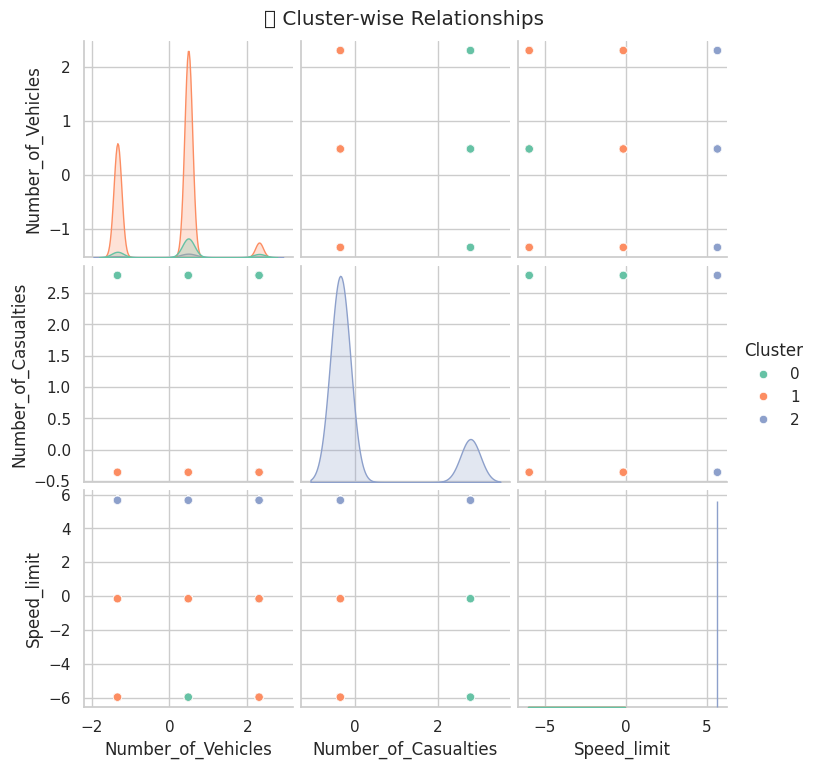

📌 Cluster Centers:
   Number_of_Vehicles  Number_of_Casualties  Speed_limit
0            0.337725              2.783515    -0.160255
1           -0.054482             -0.359258    -0.164572
2            0.337709              0.183846     5.666200


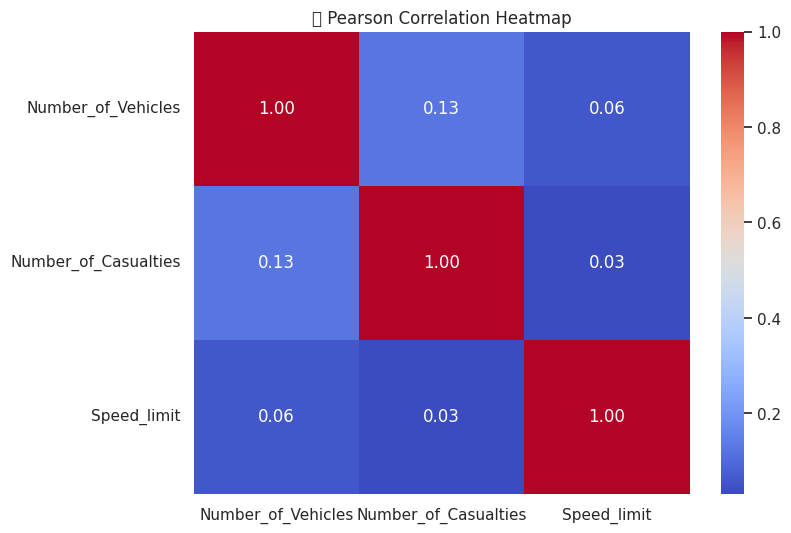

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Select features for clustering
cluster_features = ['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']
df_cluster = X_train[cluster_features]

# Fit K-Means with best K (let’s use k=3 based on earlier Silhouette score)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
X_train['Cluster'] = kmeans.fit_predict(df_cluster)

# Visualize Clusters (Pairplot)
sns.pairplot(X_train, hue='Cluster', vars=cluster_features, palette='Set2')
plt.suptitle("📊 Cluster-wise Relationships", y=1.02)
plt.show()

# Cluster Centers
print("📌 Cluster Centers:")
print(pd.DataFrame(kmeans.cluster_centers_, columns=cluster_features))

# Pearson Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(X_train[cluster_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("📈 Pearson Correlation Heatmap")
plt.show()


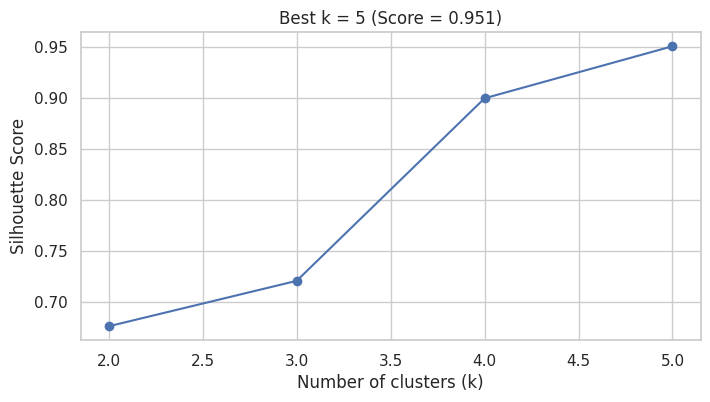

Cluster Centers:
   Number_of_Vehicles  Number_of_Casualties  Speed_limit
0            0.482858             -0.359258    -0.163113
1           -1.335804             -0.359258    -0.167510
2            0.337725              2.783515    -0.160255
3            0.337709              0.183846     5.666200
4            2.301520             -0.359258    -0.162355


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd

# Simplified K-Means clustering with automatic best-k selection
def quick_kmeans(data, max_k=5):
    scores = []
    for k in range(2, max_k+1):
        km = KMeans(n_clusters=k, n_init=10, random_state=42)
        labels = km.fit_predict(data)
        scores.append(silhouette_score(data, labels))

    # Find best k
    best_k = scores.index(max(scores)) + 2  # +2 because range starts at 2

    # Plot results
    plt.figure(figsize=(8,4))
    plt.plot(range(2, max_k+1), scores, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Best k = {best_k} (Score = {max(scores):.3f})')
    plt.grid(True)
    plt.show()

    # Return final model with best k
    best_model = KMeans(n_clusters=best_k, n_init=10, random_state=42)
    best_model.fit(data)
    return best_model

# Usage example (assuming df_cluster is your preprocessed data)
best_model = quick_kmeans(df_cluster)

# See cluster centers
print("Cluster Centers:")
print(pd.DataFrame(best_model.cluster_centers_, columns=df_cluster.columns))

# Add cluster labels to your dataframe
df_cluster['Cluster'] = best_model.labels_

In [ ]:
from sklearn.preprocessing import StandardScaler

# Step 1: Select numeric features for clustering
features = ['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']
X = df[features].dropna()

# Step 2: Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

#  Target variable
y = df['Accident_Severity']
X = df[features].dropna()
y = y.loc[X.index]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#  Decision Tree: Grid Search
tree_params = {'max_depth': [3, 5, 10, None], 'criterion': ['gini', 'entropy']}
tree_model = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_params, cv=5)
tree_model.fit(X_train, y_train)
print(" Best Decision Tree Params:", tree_model.best_params_)
y_pred_tree = tree_model.predict(X_test)
print(" Decision Tree Report:\n", classification_report(y_test, y_pred_tree))

#  KNN: Grid Search
knn_params = {'n_neighbors': [3, 5, 7, 9]}
knn_model = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5)
knn_model.fit(X_train, y_train)
print(" Best KNN Params:", knn_model.best_params_)
y_pred_knn = knn_model.predict(X_test)
print("KNN Report:\n", classification_report(y_test, y_pred_knn))


 Best Decision Tree Params: {'criterion': 'gini', 'max_depth': 3}
 Decision Tree Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       280
           2       0.00      0.00      0.00      5007
           3       0.87      1.00      0.93     34885

    accuracy                           0.87     40172
   macro avg       0.29      0.33      0.31     40172
weighted avg       0.75      0.87      0.81     40172

 Best KNN Params: {'n_neighbors': 7}
KNN Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       280
           2       0.00      0.00      0.00      5007
           3       0.87      1.00      0.93     34885

    accuracy                           0.87     40172
   macro avg       0.29      0.33      0.31     40172
weighted avg       0.75      0.87      0.81     40172



In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: Select features for clustering
features = ['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']
df_cluster = df[features].dropna()

# Step 2: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# Step 3: Fit KMeans with k=7
k = 7
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 4: Show cluster centers (in original scale)
import pandas as pd
centers_scaled = kmeans.cluster_centers_
centers_original = pd.DataFrame(scaler.inverse_transform(centers_scaled), columns=features)

print(f"KMeans Clustering Done with k={k}")
print(" Cluster Centers (Original Scale):")
print(centers_original.round(2))


KMeans Clustering Done with k=7
 Cluster Centers (Original Scale):
   Number_of_Vehicles  Number_of_Casualties  Speed_limit
0                1.00                  1.00         30.0
1                2.00                  1.00         30.0
2                2.15                  2.00         30.0
3                1.91                  1.18         40.0
4                1.00                  2.00         30.0
5                1.63                  1.08         20.0
6                3.00                  1.00         30.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Select features and target for prediction
features = ['Number_of_Vehicles', 'Number_of_Casualties', 'Speed_limit']
target = 'Accident_Severity'

# Drop missing values
df_clean = df[features + [target]].dropna()

# Prepare data
X = df_clean[features]
y = df_clean[target]

# Optional: Encode target if it's categorical text
if y.dtype == 'O':
    le = LabelEncoder()
    y = le.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 1Train Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

# 2Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

# Evaluate both models
print(" Decision Tree Results:")
print(classification_report(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))

print("\n KNN Results:")
print(classification_report(y_test, y_pred_knn))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))


 Decision Tree Results:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       280
           2       0.00      0.00      0.00      5007
           3       0.87      1.00      0.93     34885

    accuracy                           0.87     40172
   macro avg       0.29      0.33      0.31     40172
weighted avg       0.75      0.87      0.81     40172

Accuracy: 0.8683909190480932

 KNN Results:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       280
           2       0.38      0.00      0.00      5007
           3       0.87      1.00      0.93     34885

    accuracy                           0.87     40172
   macro avg       0.42      0.33      0.31     40172
weighted avg       0.80      0.87      0.81     40172

Accuracy: 0.8682913472070098
